In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1337)

# Let's build the model

We will first implement self-Attention layer.

In [17]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embd, head_size, block_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """ Input: x of shape (B, T, C), i.e. (batch size, sequence length, input channels)
          Output: tensor of shape (B, T, C)

          (1) Computes key and query representations using linear transformations.
          (2) Computes attention scores by multiplying query and key tensors and normalizing by C**-0.5.
              Masks out future information using the lower triangular matrix (you can use tril function).
              Applies softmax to get attention weights. Then, applies dropout for regularization
          (3) Computes the weighted sum of values using attention weights.
        """
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embd, head_size, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """ Input: x of shape (B, T, C), i.e. (batch size, sequence length, input channels)
          Output: tensor of shape (B, T, C)

          (1) Computes attention for each head in parallel and concatenates their outputs along the last dimension.
          (2) Projects concatenated head outputs back to the original dimension using a linear layer.
          (3) Applies dropout for regularization.
        """

        ##################################################################
        #
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
        #
        ##################################################################


It's turn for FeedForward module!

In [18]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()

        ##################################################################
        #
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
        #
        ##################################################################


    def forward(self, x):

        """ Input: x of shape (B, T, C), i.e. (batch size, sequence length, input channels)
          Output: tensor of shape (B, T, C)
        """

        ##################################################################
        #
        return self.net(x)
        #
        ##################################################################


We have all elements for creating a block now!

In [19]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, block_size):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        """
          (1) Utilizes layer normalization to preprocess the input features before passing them through the self-attention mechanism.
              Updates the input features by adding the output of the self-attention mechanism, fostering communication between different parts of the input sequence.
          (2) Utilizes layer normalization to preprocess the updated input features before passing them through the feedforward neural network.
              Updates the input features again by adding the output of the feedforward neural network, enabling the model to capture non-linear relationships and patterns within the data.
        """
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


We can now create our toy model!

In [20]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        ##################################################################
        #
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        #
        ##################################################################

        #compute loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Now, it's time to train the model.

First, download the data.

In [21]:
#Download tiny Shakespeare dataset and read it
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

Now, we will simply implement our own tokenizer. For this simple assignment, we will use __character based tokenizer__. However, keep in mind that character level tokenizer is not a common practice in real life. More complicated tokenizers are being used. For an introductory reading to tokenizers, you refer to the following video: https://youtu.be/zduSFxRajkE?si=quNy7UNMQkJ20Nim

There are __two main properties of a tokenizer: encode and decode__. Encoding function takes a string, divides it to the tokens and then converts each token to their assigned integer value. You can think about this integer assignment part as a lookup table. Decoding reverses the encoding process, converting the processed or encoded text back into its original form, allowing for human-readable interpretation or presentation.

In [22]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


Let's create train and validation splits.

In [23]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [24]:
# data loading
def get_batch(split, batch_size, block_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [25]:
#define loss estimation function for train and validation
@torch.no_grad()
def estimate_loss(batch_size, block_size, eval_iters = 200):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size, block_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Define hyperparameter

In [26]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?

max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_embd = 64
#n_head = 4
n_head = 2
n_layer = 4
dropout = 0.0

Create model and move to device

In [27]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.209729 M parameters


Let's see what model generates before training

In [28]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


DuJAMJ3fX$VWoGCYngj$'onoE,$AT-NvynticCzJ-c!bnDNyjfND,?to;rVcANzq:nf$3NVAz:YzgNkceei.-efVhpXz,NApQe.3hRfNThglUzoecXgZ q.g?d
xeo$ug:'QmZqR3F!neLZmh.TW,$-Jko.iu!seNwol$zJ,pJhwiKeo,Ssnu3blKpSpbMcSWhWmYn&UwNUc-qmfjkeRecJDeqqNWVa-?gLrR XbM ?BJxRlB;?zUC
blOHdJV
XXo;Vch.kt?Hpza:hoV.NarnDozmp zPj-!gTsoSN-FgAAuYeANEmUhNMNx- SEMxyJdyJAssmp.! OKoc,riiJ?acNQKscoiiNzAp,zciDvy-uFXQV'Vquq$Bvd-OuH,$AyEqs.,wUcLOa e$':,cJwX'TOiaBpyokP&W!T!NGUUJWS.OWo!LvFjeDfP.?,FoJgu!cXuImjNE;,jqthn,y?3T:EiOBpLm
:OgMb,xE,ol uHcI KZJKFcZpWDn3,XY
JVP'KNvdrhk!pJQJnsW3pvJ-b3,QPD3NN DfVPUeo.HwouBh
vr:wPpu!iuNJXENzHVNFq,PzeK?h.INNcmF,k,oc$qU$iuJCzuSbA$Wn,dpoPAeOzdX,nBoOzQ!Ldnsi?sAriBO.bqjouA :$VOi.&AlANczQ,yb jv.-qubZo!RN-QtAL;V:rQ,klRMsVhdypppLyGKeE-IoowJpXKMTwNxLegKUjpEzq! dZpupUetU
q D!Dl--q
,aM?W-cAL$gli;H;iivwo,RoQiaaL.C-T.&p&

p?AJHyp'OCplq3tU!IEcpodmKKPqrHe$C.,g:-A'ONJep,XignPXoOn!qUDFC;URWzXUzELD3D3N&CEOWUwXcJp,JlKsp, Dftwp:NGsIR.?cetPme?p3f'-g?,BBX,ciFzeXDt&V!rnoOwtBp
hioZNLLeyhL!sV
QvqJJlbup?UJWbJ?Upei&,
LeTanqJqJDz

Train the model

step 0: train loss 4.4045, val loss 4.3964
step 100: train loss 2.6368, val loss 2.6426
step 200: train loss 2.4858, val loss 2.4908
step 300: train loss 2.3788, val loss 2.3852
step 400: train loss 2.3180, val loss 2.3250
step 500: train loss 2.2627, val loss 2.2680
step 600: train loss 2.2226, val loss 2.2254
step 700: train loss 2.1587, val loss 2.1800
step 800: train loss 2.1203, val loss 2.1546
step 900: train loss 2.0891, val loss 2.1332
step 1000: train loss 2.0662, val loss 2.1016
step 1100: train loss 2.0332, val loss 2.0733
step 1200: train loss 2.0073, val loss 2.0498
step 1300: train loss 1.9925, val loss 2.0349
step 1400: train loss 1.9589, val loss 2.0242
step 1500: train loss 1.9411, val loss 2.0177
step 1600: train loss 1.9129, val loss 1.9930
step 1700: train loss 1.9113, val loss 2.0010
step 1800: train loss 1.8943, val loss 1.9807
step 1900: train loss 1.8736, val loss 1.9770
step 2000: train loss 1.8561, val loss 1.9568
step 2100: train loss 1.8533, val loss 1.9759


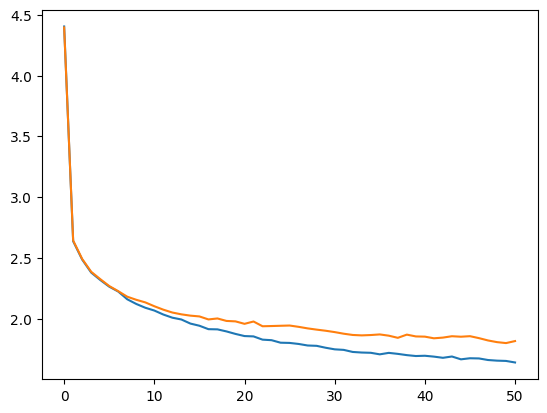

In [29]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loss = []
val_loss = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(batch_size, block_size)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train', batch_size, block_size)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.show()

Now, it's time to see the generation of a trained model!!

In [30]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Fireaticent
Awhat, lame as a hold swo helper
To soul depine is untagent one to gliff thy battless were the hears come,
Nor Oxcessly: sir, by husil.

LADY IUS:
Let eyes guily my eyes full.
When that rest by rather's genemies.

Fillo, Jureof
Make wetchirt with here care this lause.
In stay not him than souly distard grount a sween:
Ah, what her man, but in noth hanged my bargued;
And, therefor SmOUCESTER:
My say and grace.
3 HENRY Bold soveraly master you respirount off
uperse; by confuccy: so with fhile his prity. No's but use this is thy pards it. But fath he, death of yetempt,
And father not gasned towe is any sope is as was shall kin me;
When in things himself shames, then less,
A son prom mieed your last, deeppuled?

JRITH:
Wherew, and my this calens,
With lew'd and done the when noped caugness.
Bathen untient of ways? Why, so good,
Mercupard, the glot man me wear the part.

PORISSOLANUS:
The mustman you good feap the world,
From Leem Catter of iyour say, well:
thou obst day dothin